# Model Selection

Objective: Build and compare models for 3-gameweek forecasting while
          addressing the 61% zero-point distribution problem.

Model Architecture:
1. Naive Regression (Baseline)
2. Filtered Regression (Train only on playing time)
3. Two-Stage Model (Classification + Regression)

Mathematical Foundation:
For zero-inflated data, the expected value decomposes as:

E[Y] = P(Y > 0) × E[Y | Y > 0]

Two-stage approach models these components separately for better accuracy.

## Setup & Configuration


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import lightgbm as lgb

sns.set_style('darkgrid')

# Paths
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATURES_FILE = PROCESSED_DIR / "fpl_features_engineered.csv"

# Load
df = pd.read_csv(FEATURES_FILE)
print(f"Loaded: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loaded: (93666, 151)
Memory: 144.2 MB


## 1. Feature Selection

Select features for modeling, excluding:
- Target variables
- IDs and metadata
- High-cardinality strings

In [10]:
# Encode position for analysis later
df['position_encoded'] = df['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})

# Exclude columns
exclude_cols = [
    'total_points',  # Target variable
    'element', 'name', 'season', 'kickoff_time',  # IDs and metadata
    'fixture', 'opponent_team', 'team',  # High cardinality
    'match_score', 'opponent_team_name',  # Derived strings
    'round', 'modified', 'xP', 'starts',  # Redundant/sparse
    'points_above_4', 'points_above_6',  # Intermediate features
]

# Available feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Separate by category for analysis
rolling_features = [c for c in feature_cols if 'roll' in c]
lag_features = [c for c in feature_cols if 'lag' in c]
momentum_features = [c for c in feature_cols if any(x in c for x in ['momentum', 'streak', 'trend', 'acceleration'])]
position_features = [c for c in feature_cols if 'position' in c or 'vs_' in c]
xg_features = [c for c in feature_cols if 'expected' in c or 'xg' in c]
base_features = [c for c in feature_cols if c not in rolling_features + lag_features + 
                 momentum_features + position_features + xg_features]

print("Feature Categories:")
print(f"  Rolling stats: {len(rolling_features)}")
print(f"  Lags: {len(lag_features)}")
print(f"  Momentum: {len(momentum_features)}")
print(f"  Position: {len(position_features)}")
print(f"  Expected goals: {len(xg_features)}")
print(f"  Base stats: {len(base_features)}")
print(f"  TOTAL: {len(feature_cols)}")

Feature Categories:
  Rolling stats: 79
  Lags: 10
  Momentum: 7
  Position: 6
  Expected goals: 12
  Base stats: 31
  TOTAL: 136


## 2. Temporal Train-Validation-Test Split

In [11]:
def create_temporal_split(df):
    """
    Splits data maintaining strict temporal order.
    
    Train: 2021-22, 2022-23, 2023-24
    Validation: 2024-25 (GW 15+)  # CHANGED: was 20+
    Test: 2025-26 (GW 1-12)  # CHANGED: exclude last 3 GWs
    
    Returns
    -------
    tuple
        (train_df, val_df, test_df)
    """
    train_mask = df['season'].isin(['2021-22', '2022-23', '2023-24'])
    val_mask = (df['season'] == '2024-25') & (df['GW'] >= 15)  # More data
    test_mask = (df['season'] == '2025-26') & (df['GW'] <= 12)  # Leave room for targets
    
    train_df = df[train_mask].copy()
    val_df = df[val_mask].copy()
    test_df = df[test_mask].copy()
    
    print("Temporal Split:")
    print(f"  Train: {len(train_df):,} observations ({train_df['season'].unique()})")
    print(f"  Val:   {len(val_df):,} observations ({val_df['season'].unique()})")
    print(f"  Test:  {len(test_df):,} observations ({test_df['season'].unique()})")
    
    return train_df, val_df, test_df

In [12]:
train_df, val_df, test_df = create_temporal_split(df)

# Analyze zero-inflation by split
print("\nZero-Point Distribution:")
for name, data in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    zero_pct = (data['total_points'] == 0).sum() / len(data) * 100
    print(f"  {name}: {zero_pct:.1f}% zeros")

Temporal Split:
  Train: 68,398 observations (['2021-22' '2022-23' '2023-24'])
  Val:   4,881 observations (['2024-25'])
  Test:  8,818 observations (['2025-26'])

Zero-Point Distribution:
  Train: 60.5% zeros
  Val: 59.7% zeros
  Test: 60.1% zeros


## 3. Create Multi-Horizon Targets

In [13]:
def create_targets(df, horizons=[1, 2, 3]):
    """
    Creates target variables for each forecast horizon.
    Also creates binary classification target (will_play).
    
    Returns
    -------
    pd.DataFrame
        DataFrame with target_h1, target_h2, target_h3, will_play_h1, etc.
    """
    df = df.sort_values(['element', 'season', 'GW']).copy()
    
    for h in horizons:
        # Regression target (points)
        df[f'target_h{h}'] = df.groupby('element')['total_points'].shift(-h)
        
        # Classification target (will play?)
        df[f'will_play_h{h}'] = (df.groupby('element')['minutes'].shift(-h) > 0).astype(int)
    
    # Remove rows without targets (last 3 GWs per player)
    df = df.dropna(subset=[f'target_h{h}' for h in horizons])
    
    print(f"Created targets for horizons: {horizons}")
    print(f"Final observations: {len(df):,}")
    
    return df

In [14]:
train_df = create_targets(train_df)
val_df = create_targets(val_df)
test_df = create_targets(test_df)

Created targets for horizons: [1, 2, 3]
Final observations: 65,911
Created targets for horizons: [1, 2, 3]
Final observations: 2,737
Created targets for horizons: [1, 2, 3]
Final observations: 6,564


## 4. Prepare Feature Matrices

In [15]:
def prepare_features(df, feature_cols):
    """
    Prepares feature matrix with missing value handling.
    
    Returns
    -------
    np.ndarray
        Feature matrix
    """
    X = df[feature_cols].copy()
    
    # Encode categorical first (before filling NaN)
    if 'position' in X.columns:
        X['position'] = X['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})
    
    if 'was_home' in X.columns:
        X['was_home'] = X['was_home'].fillna(0).astype(int)  # Fill NaN before converting
    
    # Fill remaining missing values with median
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Final safety: fill any remaining NaN with 0
    X = X.fillna(0)
    
    return X.values

In [16]:
# Prepare feature matrices
X_train = prepare_features(train_df, feature_cols)
X_val = prepare_features(val_df, feature_cols)
X_test = prepare_features(test_df, feature_cols)

print("Feature matrix shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

Feature matrix shapes:
  Train: (65911, 136)
  Val:   (2737, 136)
  Test:  (6564, 136)


c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\kadmi\AppData\Local\Temp\ipykernel_14956\2702608609.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

## 5. Approach 1: Naive Regression (Baseline)

Train on all data, including zeros.

In [17]:
def train_naive_regression(X_train, y_train, X_val, y_val, horizon):
    """
    Trains standard LightGBM regressor on all data.
    
    Returns
    -------
    tuple
        (model, val_mae, val_rmse, predictions)
    """
    # LightGBM parameters (moderate to avoid overfitting)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    return model, mae, rmse, r2, y_pred

In [18]:
print("="*70)
print("APPROACH 1: NAIVE REGRESSION")
print("="*70)

naive_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    
    model, mae, rmse, r2, y_pred = train_naive_regression(X_train, y_train, X_val, y_val, h)
    
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}")
    
    naive_results[h] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

APPROACH 1: NAIVE REGRESSION

Horizon 1:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l1: 1.06719
  MAE:  1.067
  RMSE: 1.992
  R²:   0.323

Horizon 2:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's l1: 1.11012
  MAE:  1.110
  RMSE: 1.994
  R²:   0.281

Horizon 3:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's l1: 1.10061
  MAE:  1.101
  RMSE: 1.951
  R²:   0.275


## 6. Approach 2: Filtered Regression

rain only on observations where player actually played (minutes > 0).
Then apply to all validation data.


In [19]:
def train_filtered_regression(train_df, X_train, y_train, X_val, y_val, horizon):
    """
    Trains on playing-time observations only.
    
    Strategy:
    - Filter training data to minutes > 0
    - Train regressor on this subset
    - Predict on full validation set (including non-players)
    
    Returns
    -------
    tuple
        (model, val_mae, val_rmse, predictions)
    """
    # Filter to playing time
    playing_mask = train_df['minutes'] > 0
    X_train_playing = X_train[playing_mask]
    y_train_playing = y_train[playing_mask]
    
    print(f"  Training on {len(y_train_playing):,} / {len(y_train):,} observations ({len(y_train_playing)/len(y_train)*100:.1f}% playing)")
    
    # Train model
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    train_data = lgb.Dataset(X_train_playing, label=y_train_playing)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Predict on full validation (including non-players)
    y_pred = model.predict(X_val)
    
    # Clip negative predictions to 0
    y_pred = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    return model, mae, rmse, r2, y_pred


In [20]:
print("="*70)
print("APPROACH 2: FILTERED REGRESSION")
print("="*70)

filtered_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    
    model, mae, rmse, r2, y_pred = train_filtered_regression(train_df, X_train, y_train, X_val, y_val, h)
    
    print(f"  MAE:  {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  R²:   {r2:.3f}")
    
    filtered_results[h] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

APPROACH 2: FILTERED REGRESSION

Horizon 1:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's l1: 1.28902
  MAE:  1.289
  RMSE: 2.062
  R²:   0.275

Horizon 2:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	valid_0's l1: 1.34665
  MAE:  1.347
  RMSE: 2.054
  R²:   0.237

Horizon 3:
  Training on 27,598 / 65,911 observations (41.9% playing)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's l1: 1.33477
  MAE:  1.335
  RMSE: 1.998
  R²:   0.240


## 7. Approach 3: Two-Stage Model 


Mathematical decomposition:

*E[points] = P(minutes > 0) × E[points | minutes > 0]*

- Stage 1: Classifier predicts P(will play)
- Stage 2: Regressor predicts E[points | playing]
- Final: Ensemble both predictions

In [ ]:
def train_two_stage_model(train_df, X_train, X_val, y_train, y_val, y_train_binary, y_val_binary, horizon):
    """
    Two-stage model: Classification + Regression.
    
    Stage 1: Binary classifier for P(minutes > 0)
    Stage 2: Regressor for E[points | minutes > 0]
    Ensemble: final_pred = prob_playing × points_if_playing
    
    Returns
    -------
    tuple
        (classifier, regressor, val_mae, val_rmse, predictions)
    """
    print("  Stage 1: Training classifier (will play?)")
    
    # === STAGE 1: CLASSIFICATION ===
    clf_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'verbose': -1,
        'random_state': 42
    }
    
    clf_train = lgb.Dataset(X_train, label=y_train_binary)
    clf_val = lgb.Dataset(X_val, label=y_val_binary)
    
    classifier = lgb.train(
        clf_params,
        clf_train,
        num_boost_round=300,
        valid_sets=[clf_val],
        callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=0)]
    )
    
    # Classifier predictions
    prob_playing = classifier.predict(X_val)
    
    # Classifier metrics
    y_pred_binary = (prob_playing > 0.5).astype(int)
    acc = accuracy_score(y_val_binary, y_pred_binary)
    auc = roc_auc_score(y_val_binary, prob_playing)
    print(f"    Accuracy: {acc:.3f}, AUC: {auc:.3f}")
    
    # === STAGE 2: REGRESSION ===
    print("  Stage 2: Training regressor (points if playing)")
    
    # Train only on players who actually played
    playing_mask = train_df['minutes'] > 0
    X_train_playing = X_train[playing_mask]
    y_train_playing = y_train[playing_mask]
    
    print(f"    Training on {len(y_train_playing):,} playing observations")
    
    reg_params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    reg_train = lgb.Dataset(X_train_playing, label=y_train_playing)
    reg_val = lgb.Dataset(X_val, label=y_val)
    
    regressor = lgb.train(
        reg_params,
        reg_train,
        num_boost_round=500,
        valid_sets=[reg_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Regressor predictions
    points_if_playing = regressor.predict(X_val)
    points_if_playing = np.maximum(points_if_playing, 0)  # Clip negatives
    
    # === ENSEMBLE ===
    final_predictions = prob_playing * points_if_playing
    
    # Metrics on ensemble
    mae = mean_absolute_error(y_val, final_predictions)
    rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
    r2 = r2_score(y_val, final_predictions)
    
    return classifier, regressor, mae, rmse, r2, final_predictions, prob_playing


In [22]:
print("="*70)
print("APPROACH 3: TWO-STAGE MODEL")
print("="*70)

two_stage_results = {}

for h in [1, 2, 3]:
    print(f"\nHorizon {h}:")
    
    y_train = train_df[f'target_h{h}'].values
    y_val = val_df[f'target_h{h}'].values
    y_train_binary = train_df[f'will_play_h{h}'].values
    y_val_binary = val_df[f'will_play_h{h}'].values
    
    clf, reg, mae, rmse, r2, y_pred, prob = train_two_stage_model(
        train_df, X_train, X_val, y_train, y_val, y_train_binary, y_val_binary, h
    )
    
    print(f"  Final MAE:  {mae:.3f}")
    print(f"  Final RMSE: {rmse:.3f}")
    print(f"  Final R²:   {r2:.3f}")
    
    two_stage_results[h] = {
        'classifier': clf,
        'regressor': reg,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred,
        'prob_playing': prob
    }

APPROACH 3: TWO-STAGE MODEL

Horizon 1:
  Stage 1: Training classifier (will play?)
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.938768
    Accuracy: 0.877, AUC: 0.939
  Stage 2: Training regressor (points if playing)
    Training on 27,598 playing observations
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's l1: 1.28902
  Final MAE:  0.996
  Final RMSE: 2.027
  Final R²:   0.299

Horizon 2:
  Stage 1: Training classifier (will play?)
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.912403
    Accuracy: 0.844, AUC: 0.912
  Stage 2: Training regressor (points if playing)
    Training on 27,598 playing observations
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	valid_0's l1: 1.34665
  Final MAE:  1.008
  Final RMSE: 2.019
  Final R

## 8. Model Comparison

MODEL COMPARISON: MEAN ABSOLUTE ERROR
           Naive Regression  Filtered Regression  Two-Stage Model
Horizon 1             1.067                1.289            0.996
Horizon 2             1.110                1.347            1.008
Horizon 3             1.101                1.335            0.980

Improvement over Naive Baseline:

Filtered Regression:
  Horizon 1: -20.8%
  Horizon 2: -21.3%
  Horizon 3: -21.3%

Two-Stage Model:
  Horizon 1: 6.7%
  Horizon 2: 9.2%
  Horizon 3: 10.9%


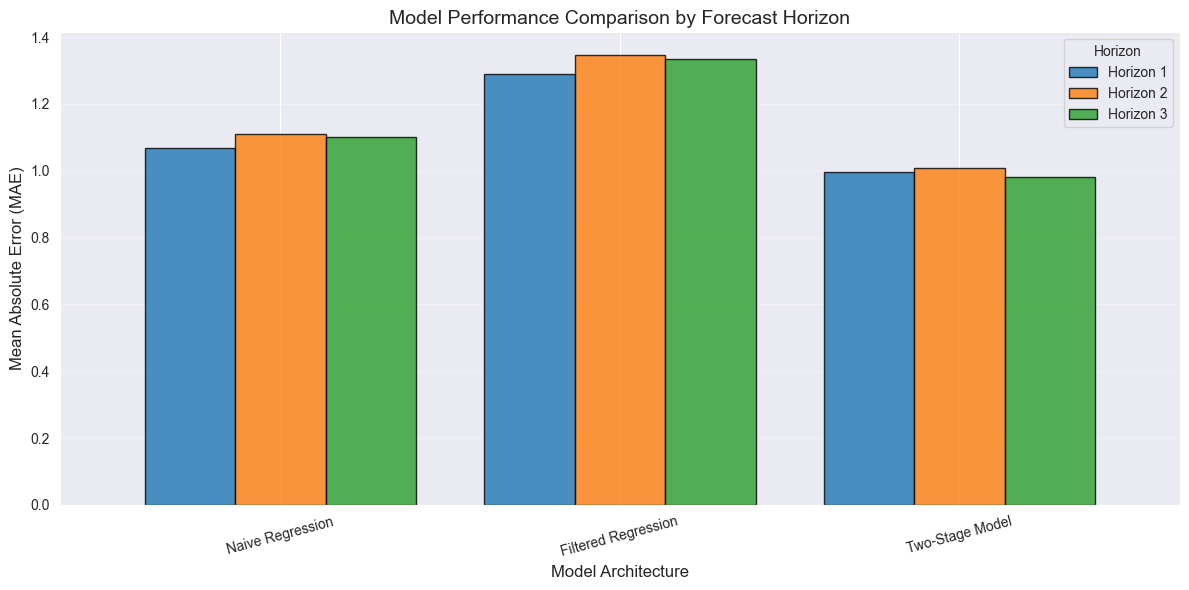

In [23]:
# Compile results
comparison = pd.DataFrame({
    'Naive Regression': [naive_results[h]['mae'] for h in [1,2,3]],
    'Filtered Regression': [filtered_results[h]['mae'] for h in [1,2,3]],
    'Two-Stage Model': [two_stage_results[h]['mae'] for h in [1,2,3]]
}, index=['Horizon 1', 'Horizon 2', 'Horizon 3'])

print("="*70)
print("MODEL COMPARISON: MEAN ABSOLUTE ERROR")
print("="*70)
print(comparison.round(3))

# Calculate improvement over naive
print("\nImprovement over Naive Baseline:")
for model in ['Filtered Regression', 'Two-Stage Model']:
    improvements = (comparison['Naive Regression'] - comparison[model]) / comparison['Naive Regression'] * 100
    print(f"\n{model}:")
    for h in [1, 2, 3]:
        print(f"  Horizon {h}: {improvements.iloc[h-1]:.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
comparison.T.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)
ax.set_xlabel('Model Architecture', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_title('Model Performance Comparison by Forecast Horizon', fontsize=14)
ax.legend(title='Horizon', loc='upper right')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()